# Random bathymetry generator
In this script, an attempt is made to generate 'new' bathymetry which retains the spectral characteristics of the original bathymetry.  
The approach is the same as in the 1D case of Ebisuzaki (1997, [doi](https://doi.org/10.1175/1520-0442(1997)010%3C2147:AMTETS%3E2.0.CO;2)) in which a random perturbation is added to the phase of the discrete Fourier transform.  
This code is originally from Tom Bolton, tweaked and adapted to work with a bathymetric dataset.

In [116]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
from ranthymetry import gen_samples
# import xrft
%matplotlib inline

In [117]:
# Load data #
# ETOPO: /work/gam/ETOPO1/ETOPO1_Ice_g_gmt4.grd
# SRTM topo15: /work/gam/srtm/topo15.grd

filename = '/work/gam/ETOPO1/ETOPO1_Ice_g_gmt4.grd'
ds = xr.open_dataset(filename)
ds = ds.rename({'x':'lon','y':'lat'})

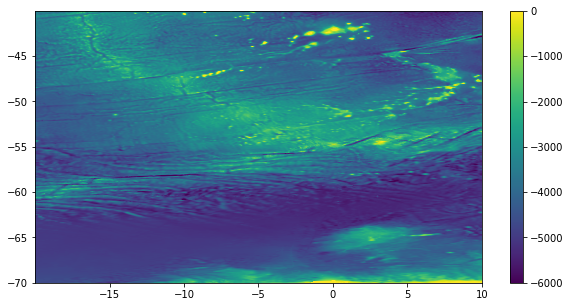

In [118]:
# Select subsection of data
LAT=[-70,-40]
LON=[-20,10]
f = ds.z.sel(lat=slice(LAT[0],LAT[1]),lon=slice(LON[0],LON[1]))
f = xr.where(f>0,0,f)

fig, ax = plt.subplots( 1, 1, figsize=(10,5) )
im = ax.pcolormesh(f.lon,f.lat,f.values)
plt.colorbar(im,ax=ax)
im.set_clim([-6000,0])
#im = ax[1].plot(f.lon,f.values[0,:])
#ax[1].set_ylim([-6000,0])
#ax[1].set_xlim(LON)

***
This is a function to apply a random phase shift to the 2D Fourier Transform of bathymetric data  

In [119]:
def gen_samples( f, n_samples, apply_hamming=True ) :
    """
    Estimate the 2D power spectrum of the input
    field f, and use random phase sampling to produce
    n_samples of f with the same spectrum of f.
    
    Inputs
    f : 2D array, field to produce samples of
    n_samples : integar, number of samples to generate
    
    Outputs
    samples : 3D array containing the samples of 2D fields
    
    """
    Ny, Nx = f.shape
    
    # applying Hamming window
    if apply_hamming :
        
        w_x = np.hamming(Nx)
        w_y = np.hamming(Ny)
        
        win = np.sqrt( np.outer( w_y, w_x ) )
        
        f *= win
    
    samples = np.zeros( (n_samples,Ny,Nx) )
    samples_spec = np.empty( (n_samples,Ny,Nx) )
    
    # calculate mean and std of f
    f_mean = np.mean(f)
    f_sig = np.std(f)
    
    # remove mean
    f -= f_mean
    
    # 2D power spectrum calculation
    dft = np.fft.fft2(f)            # compute 2D dft
    #dft = np.fft.fftshift( psd )    # shift zero frequency
    
    mod = np.abs(dft)
    
    for i in range(n_samples) :
        
        # generate 2D grid of random phases
        # between 0 and 2pi
        phase_x = np.zeros( Nx )
        phase_y = np.zeros( Ny )
        # In the following, impose zero in first entry of randomised phases
        # Procedure:
            # Randomise entries in phase_* from index 1 to Nx/2
            # (remember in python, index Nx/2 is the entry one greater than the mid-point)
                # e.g. phase_x = [0 1 2 3 4 0 0 0]
            # Take entries 1 to Nx/2, set them to negative, reverse their order,
            # and put them into phase_* in entries Nx/2 to end
                # e.g. phase_x = [0 1 2 3 -4 -3 -2 -1]
            # Note that index Nx/2 is set in the first step and then just reversed in sign
            # For an odd number of entries, the entry in index Nx/2 is set twice...
                # e.g. step 1: phase_x = [0 1 2 3 4 0 0 0 0]
                # then step 2: phase_x = [0 1 2 3 4 -4 -3 -2 -1]
        
        if Nx % 2 == 0 :
            
            phase_x[1:int(Nx/2+1)] = np.random.uniform( size=int(Nx/2) ) * 2 *np.pi
            phase_x[int(Nx/2):] = np.flip(-phase_x[1:int(Nx/2+1)])
            
        else :
            
            phase_x[1:int((Nx-1)/2+1)] = np.random.uniform( size=int( (Nx-1)/2) ) * 2 *np.pi
            phase_x[int((Nx-1)/2+1):] = np.flip(-phase_x[1:int((Nx-1)/2+1)])
            
        if Ny % 2 == 0 :
            
            phase_y[1:int(Ny/2+1)] = np.random.uniform( size=int(Ny/2) ) * 2 *np.pi
            phase_y[int(Ny/2):] = np.flip(-phase_y[1:int(Ny/2+1)])
            
        else :
            
            phase_y[1:int((Ny-1)/2+1)] = np.random.uniform( size=int( (Ny-1)/2) ) * 2 *np.pi
            phase_y[int((Ny-1)/2+1):] = np.flip(-phase_y[1:int((Ny-1)/2+1)])
            
        
        phase_x, phase_y = np.meshgrid( phase_x, phase_y )
            
        # use random phases to construct
        # new 2D sample with same spectrum
        f_spec = mod * np.exp( 1j * phase_x + 1j * phase_y  )
        
        # invert the sample power spectrum
        # and reintroduce mean
        f_sample = np.real( np.fft.ifft2( f_spec ) )
        f_sample += f_mean
        
        # re-scale to variance of original f
        f_sample /= np.std( f_sample )
        f_sample *= f_sig
        
        samples[i,:,:] = f_sample
        samples_spec[i,:,:] = f_spec
        
        
    return samples, samples_spec, dft, phase_x, phase_y

***
To dig into what the function is doing, we just generate one sample.
We output the original DFT, the DFT with randomly perturbed phase, and newly generated bathymetry (inverse DFT of perturbed DFT).

In [124]:
n=1
samples, samples_spec, dft, px, py = gen_samples(-f.values,n_samples=n,apply_hamming=False)

/nbhome/gam/miniconda/envs/mom6/lib/python3.7/site-packages/ipykernel_launcher.py:99: ComplexWarning: Casting complex values to real discards the imaginary part


### Let us first plot the power spectra for the original bathymetry and for the randomly perturbed DFT.  
It appears as though the randomization has quite a substantial impact on the power spectrum, unless I am misinterpreting.

In [ ]:
# Plot original power spectra for dft and randomly generated dft
fig, ax = plt.subplots( 3, 2, figsize=(10,5) )
# Original
im=ax[0,0].pcolormesh(np.log10(np.abs(dft)**2))
plt.colorbar(im,ax=ax[0,0])
im=ax[1,0].plot(np.log10(np.abs(dft[np.int(np.round(dft.shape[0]/2)),:])**2))
# Random
s = samples_spec[0,:,:]
im=ax[0,1].pcolormesh(np.log10(np.abs(s)**2))
plt.colorbar(im,ax=ax[0,1])
im=ax[1,1].plot(np.log10(np.abs(s[np.int(np.round(s.shape[0]/2)),:])**2))

### Take the inverse FT to reproduce the bathymetry implied by the spectra above
We can see that the perturbed bathymetry is evidently different from the original

In [ ]:
# Take inverse fourier transforms
fig, ax = plt.subplots( 1, 2, figsize=(10,5) )
# Original
f_new = np.fft.ifft2(dft)
im=ax[0].pcolormesh(np.real(f_new))
plt.colorbar(im,ax=ax[0])
# Random
s = samples_spec[0,:,:]
f_new = np.fft.ifft2(s)
im=ax[1].pcolormesh(np.real(f_new))
plt.colorbar(im,ax=ax[1])

***
As above (reproduced bathymetry), but now directly output from function, with mean added back in and variance rescaled.

In [ ]:
# Plot original and new topography
fig, ax = plt.subplots( 1, 2, figsize=(10,5) )
# Original
im=ax[0].pcolormesh(np.real(f))
plt.colorbar(im,ax=ax[0])
# Random
im=ax[1].pcolormesh(-samples[0,:,:])
plt.colorbar(im,ax=ax[1])

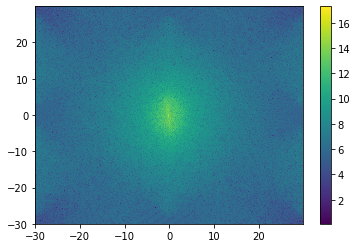

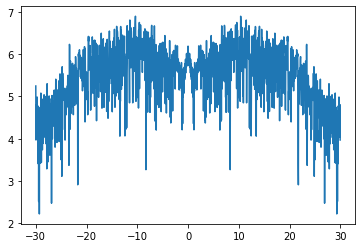

In [32]:
# XRFT
# Perform discrete Fourier transform using xrft
dft = xrft.dft(f,window=True,detrend='constant')
im=plt.pcolormesh(dft.freq_lon,dft.freq_lat,np.log10(np.abs(dft)**2))
plt.colorbar(im)
plt.show()
im=plt.plot(dft.freq_lon,np.log10(np.abs(dft.values[0,:])**2))